# Word2Vec training

This notebook is based on the [word2vec-pytorch](https://github.com/OlgaChernytska/word2vec-pytorch/tree/18d4f24c4d82dde76de9f6e4d88bbcbcf68befc2) repo.

In [ ]:
%%bash
wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
unzip wikitext-2-v1.zip

In [1]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader


import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.rcParams.update({'font.size': 14})

In [7]:
TRAIN_TOKENS = 'wikitext-2/wiki.train.tokens'
VALID_TOKENS = 'wikitext-2/wiki.valid.tokens'

SKIPGRAM_N_WORDS = 4
MIN_WORD_FREQUENCY = 5
MAX_SEQUENCE_LENGTH = 256

EMBED_DIM = 256
EMBED_MAX_NORM = 1
BATCH_SIZE = 16
NUM_EPOCHS = 20

In [3]:
from torchtext.data.utils import get_tokenizer


tokenizer = get_tokenizer("basic_english", language="en")


def load_and_preprocess_dataset(path):
    with open(path, 'r') as file:
        lines = file.readlines()

    data = list(filter(
        lambda sent: len(sent) > SKIPGRAM_N_WORDS * 2,
        map(tokenizer, lines)
    ))

    return data

In [4]:
train_data = load_and_preprocess_dataset(TRAIN_TOKENS)
valid_data = load_and_preprocess_dataset(VALID_TOKENS)

total_train_tokens = sum(len(sent) for sent in train_data)
total_valid_tokens = sum(len(sent) for sent in valid_data)

print(f'Num sentences: train - {len(train_data)}, valid - {len(valid_data)})')
print(f'Total tokens: train - {total_train_tokens}, valid - {total_valid_tokens})')
print(f'Average tokens in sentence: {total_train_tokens / len(train_data):.2f}')

Num sentences: train - 17715, valid - 1892)
Total tokens: train - 2014338, valid - 211057)
Average tokens in sentence: 113.71


In [5]:
_ = sns.displot([len(sent) for sent in train_data])

In [8]:
from torchtext.vocab import build_vocab_from_iterator


vocab = build_vocab_from_iterator(train_data, specials=["<unk>"], min_freq=MIN_WORD_FREQUENCY)
vocab.set_default_index(vocab["<unk>"])

VOCAB_SIZE = len(vocab)
print(f'Vocab size: {VOCAB_SIZE}')

Vocab size: 20323


In [13]:
train_data[250]

['cullen',
 'was',
 'a',
 'standout',
 'with',
 'bu',
 'he',
 'was',
 'named',
 'the',
 'east',
 'coast',
 'athletic',
 'conference',
 'rookie',
 'of',
 'the',
 'year',
 'in',
 '1983',
 '–',
 '84',
 'after',
 'leading',
 'his',
 'team',
 'in',
 'scoring',
 'with',
 '56',
 'points',
 '.',
 'the',
 'national',
 'hockey',
 'league',
 'passed',
 'him',
 'over',
 ',',
 'however',
 ',',
 'as',
 'he',
 'went',
 '<unk>',
 'in',
 'the',
 '1984',
 'nhl',
 'entry',
 'draft',
 '.',
 'he',
 'was',
 'named',
 'to',
 'the',
 'hockey',
 'east',
 'all',
 '@-@',
 'star',
 'teams',
 'in',
 '1985',
 ',',
 '1986',
 'and',
 '1987',
 ',',
 'and',
 'a',
 'national',
 'collegiate',
 'athletic',
 'association',
 'east',
 'second',
 'team',
 'all',
 '@-@',
 'american',
 'in',
 '1986',
 '.',
 'he',
 'graduated',
 'as',
 'bu',
 "'",
 's',
 'all',
 '@-@',
 'time',
 'scoring',
 'leader',
 'with',
 '241',
 'points',
 ',',
 'and',
 'was',
 'named',
 'to',
 'bu',
 "'",
 's',
 'hockey',
 'east',
 '25th',
 'anniversary',

In [14]:
vocab(train_data[250])

[4292,
 9,
 8,
 11969,
 17,
 16576,
 27,
 9,
 245,
 1,
 214,
 575,
 2552,
 1162,
 6306,
 4,
 1,
 84,
 6,
 2950,
 44,
 4873,
 45,
 582,
 26,
 158,
 6,
 1342,
 17,
 2584,
 633,
 3,
 1,
 168,
 3270,
 220,
 849,
 77,
 65,
 2,
 103,
 2,
 13,
 27,
 489,
 0,
 6,
 1,
 1886,
 3415,
 2413,
 1783,
 3,
 27,
 9,
 245,
 7,
 1,
 3270,
 214,
 59,
 11,
 315,
 989,
 6,
 1920,
 2,
 1514,
 5,
 1875,
 2,
 5,
 8,
 168,
 8417,
 2552,
 659,
 214,
 95,
 158,
 59,
 11,
 150,
 6,
 1514,
 3,
 27,
 5969,
 13,
 16576,
 10,
 14,
 59,
 11,
 58,
 1342,
 1788,
 17,
 18100,
 633,
 2,
 5,
 9,
 245,
 7,
 16576,
 10,
 14,
 3270,
 214,
 5894,
 2912,
 158,
 6,
 294,
 3]

In [18]:
vocab(['123210312030213'])

[0]

In [22]:
def collate_fn(batch):
    """
    Collate_fn for Skip-Gram model to be used with Dataloader.
    `batch` is expected to be list of text paragrahs.

    Context is represented as N=SKIPGRAM_N_WORDS past words 
    and N=SKIPGRAM_N_WORDS future words.

    Long paragraphs will be truncated to contain
    no more that MAX_SEQUENCE_LENGTH tokens.

    Each element in `batch_input` is a middle word.
    Each element in `batch_output` is a context word.
    """
    batch_input, batch_output = [], []
    for text in batch:
        text_tokens_ids = vocab(text)

        if MAX_SEQUENCE_LENGTH:
            text_tokens_ids = text_tokens_ids[:MAX_SEQUENCE_LENGTH]

        for idx in range(len(text_tokens_ids) - SKIPGRAM_N_WORDS * 2):
            token_id_sequence = text_tokens_ids[idx : (idx + SKIPGRAM_N_WORDS * 2 + 1)]
            input_ = token_id_sequence.pop(SKIPGRAM_N_WORDS)
            outputs = token_id_sequence

            batch_input += [input_] * len(outputs)
            batch_output += outputs

    batch_input = torch.LongTensor(batch_input)
    batch_output = torch.LongTensor(batch_output)

    return batch_input, batch_output

In [23]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    num_workers=8,
    pin_memory=True,
    collate_fn=collate_fn,
    shuffle=True
)

valid_loader = DataLoader(
    valid_data,
    batch_size=BATCH_SIZE,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn,
    shuffle=False
)

In [24]:
next(iter(train_loader))

[tensor([30, 30, 30,  ..., 24, 24, 24]),
 tensor([  36,  635,   43,  ...,   44, 2470,    3])]

In [25]:
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Optimizer
from tqdm import tqdm


def train(model: nn.Module, data_loader: DataLoader, optimizer: Optimizer, loss_fn, device: torch.device):
    model.train()

    total_loss = 0

    for x, y in tqdm(data_loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        loss.backward()

        total_loss += loss.item()
        
        optimizer.step()

    return total_loss / len(data_loader)


In [26]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


@torch.inference_mode()
def evaluate(model: nn.Module, data_loader: DataLoader, loss_fn, device: torch.device):
    model.eval()

    total_loss = 0

    for x, y in tqdm(data_loader):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

    return total_loss / len(data_loader)


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style='darkgrid')


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()

    plt.show()

In [28]:
from IPython.display import clear_output


def fit(model, train_loader, valid_loader, optimizer, loss_fn, device, num_epochs, title, scheduler=None):
    train_loss_history, valid_loss_history = [], []

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, optimizer, loss_fn, device)
        valid_loss = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        
        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            title
        )
        
        if scheduler is not None:
            scheduler.step()

In [29]:
from torch import nn


class Word2VecModel(nn.Module):
    def __init__(self, embed_dim, embed_max_norm, vocab_size):
        super().__init__()
        
        self.embeds = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            max_norm=embed_max_norm
        )

        self.decoder = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        return self.decoder(self.embeds(x))

In [30]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

loss_fn = nn.CrossEntropyLoss()

cuda:0
NVIDIA GeForce RTX 3090 Ti


In [31]:
model = Word2VecModel(
    embed_dim=EMBED_DIM,
    embed_max_norm=EMBED_MAX_NORM,
    vocab_size=VOCAB_SIZE
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, NUM_EPOCHS)

fit(model, train_loader, valid_loader, optimizer, loss_fn, device, NUM_EPOCHS, 'Word2Vec model', scheduler)

 10%|█████▏                                            | 114/1108 [00:03<00:31, 31.50it/s]


KeyboardInterrupt: 

In [32]:
import re


def get_similarities(embed_vector):
    similarities = embed_matrix @ embed_vector / embed_norms / torch.norm(embed_vector)
    top_indices = similarities.argsort(descending=True)
    return similarities, top_indices


def get_similar(query, num_similar=5):
    print(f'Processing query \"{query}\"')
    split_query = re.split('([^a-zA-Z0-9])', query)
    index = vocab[split_query[0]]
    embed_vector = torch.clone(embed_matrix[index])
    if index > 0:
        print(f'Found word \"{split_query[0]}\" in vocab')
    else:
        print(f'Word \"{split_query[0]}\" not in vocab, using <unk>')

    for i in range(2, len(split_query), 2):
        index = vocab[split_query[i]]
        if index > 0:
            print(f'Found word \"{split_query[i]}\" in vocab, ', end='')
        else:
            print(f'Word \"{split_query[i]}\" not in vocab, using <unk>, ', end='')
        print(f'operation \"{split_query[i - 1]}\"')

        if split_query[i - 1] == '+':
            embed_vector += embed_matrix[index]
        elif split_query[i - 1] == '-':
            embed_vector -= embed_matrix[index]
        else:
            raise ValueError('Unknown operation')

    similarities, top_indices = get_similarities(embed_vector)

    itos = vocab.get_itos()
    print('Top similar:')
    for top_index in top_indices[:num_similar]:
        print(f'    {itos[top_index]}: sim = {similarities[top_index]:.4f}')

In [33]:
embed_matrix = model.embeds.weight.detach().cpu()
embed_norms = (embed_matrix ** 2).sum(1).sqrt()

In [34]:
get_similar('woman')

Processing query "woman"
Found word "woman" in vocab
Top similar:
    woman: sim = 1.0000
    girl: sim = 0.8384
    man: sim = 0.7928
    jealous: sim = 0.7711
    lover: sim = 0.7699


In [35]:
get_similar('kick')

Processing query "kick"
Found word "kick" in vocab
Top similar:
    kick: sim = 1.0000
    ecu: sim = 0.8740
    touchdown: sim = 0.8709
    tech: sim = 0.8507
    punt: sim = 0.8372


In [36]:
get_similar('help')

Processing query "help"
Found word "help" in vocab
Top similar:
    help: sim = 1.0000
    try: sim = 0.7662
    keep: sim = 0.7628
    compelled: sim = 0.7558
    bring: sim = 0.7531


In [37]:
get_similar('bread')

Processing query "bread"
Found word "bread" in vocab
Top similar:
    bread: sim = 1.0000
    cheese: sim = 0.7397
    widows: sim = 0.6725
    ceramics: sim = 0.6379
    wheat: sim = 0.6304


In [39]:
get_similar('man', num_similar=10)

Processing query "man"
Found word "man" in vocab
Top similar:
    man: sim = 1.0000
    mega: sim = 0.8200
    woman: sim = 0.7928
    bearded: sim = 0.7899
    boss: sim = 0.7763
    bass: sim = 0.7552
    girl: sim = 0.7480
    backhand: sim = 0.6791
    someone: sim = 0.6778
    pirate: sim = 0.6730


In [40]:
v = get_similar('king-man+woman', num_similar=10)

Processing query "king-man+woman"
Found word "king" in vocab
Found word "man" in vocab, operation "-"
Found word "woman" in vocab, operation "+"
Top similar:
    king: sim = 0.8456
    hairan: sim = 0.7355
    amlaíb: sim = 0.7281
    lord: sim = 0.7247
    ballala: sim = 0.7158
    veera: sim = 0.7111
    henry: sim = 0.7078
    son: sim = 0.7074
    eldest: sim = 0.7074
    edward: sim = 0.7002


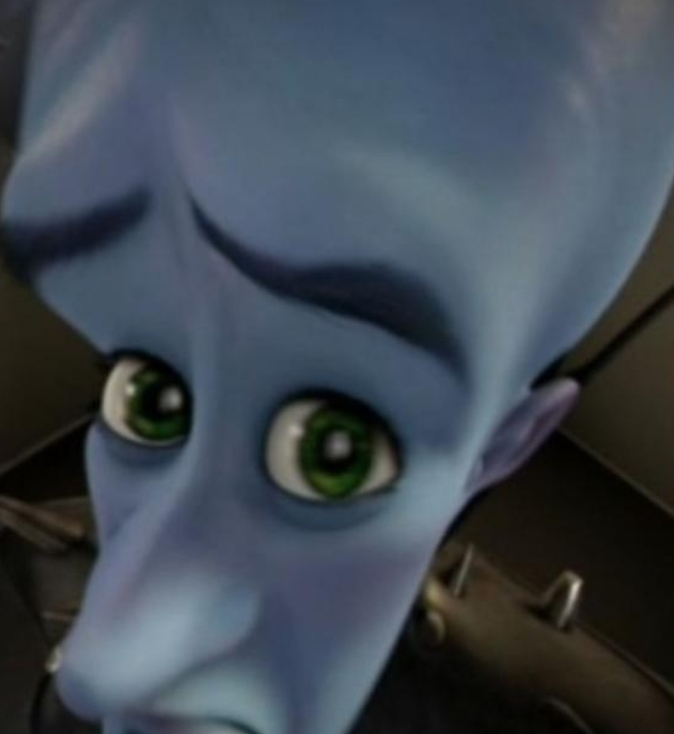

NO QUEEN?

# FastText for sentiment classification

In [ ]:
%%bash
kaggle datasets download -d shivkumarganesh/bumble-dating-app-google-play-store-review
unzip bumble-dating-app-google-play-store-review.zip

In [41]:
import pandas as pd
import fasttext
import fasttext.util

In [42]:
fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')

In [43]:
ft.get_word_vector('mother').shape

(300,)

In [45]:
ft.get_nearest_neighbors('dog')

[(0.8463464975357056, 'dogs'),
 (0.7873005270957947, 'puppy'),
 (0.7692237496376038, 'pup'),
 (0.7435278296470642, 'canine'),
 (0.733370840549469, 'pet'),
 (0.7326501607894897, 'doggie'),
 (0.7242385745048523, 'dog--'),
 (0.7231176495552063, 'beagle'),
 (0.7229929566383362, 'dachshund'),
 (0.7078613042831421, 'cat')]

In [46]:
data = pd.read_csv('bumble_google_play_reviews.csv')
data = data[data.content.notna()]
data

reviewId         userName  \
0       92746ae9-f843-4273-9cde-dafbcf09293c    Grim gonzalez   
1       c1ac87c4-09a1-448d-bfde-9a424cb661a7     Jeet Chauhan   
2       5ab2d51a-3f3a-4f2c-a23e-6e0a24bf1987        Natalie T   
3       a2d1775b-64ff-4ade-8c55-79c7266940e8  David Scrivener   
4       cedefe80-a088-4eb4-8056-cd181e63470c            Tio A   
...                                      ...              ...   
119790  61bc7cdc-3085-4631-ac95-d8e42e2e0742    A Google user   
119791  24d07489-88ad-496a-80ce-8f137c130323    A Google user   
119792  22a42d0d-7a12-400d-a2af-826f35d21581    A Google user   
119793  2480a41f-8863-4948-9f83-7d856bd9dc78    A Google user   
119794  6ebb270a-3b4b-4ff5-b98c-8899dcfd40ee    A Google user   

                                                userImage  \
0       https://play-lh.googleusercontent.com/a-/ACNPE...   
1       https://play-lh.googleusercontent.com/a-/ACNPE...   
2       https://play-lh.googleusercontent.com/a-/ACNPE...   
3       https://play-lh.googleusercontent.com/a-/ACNPE...   
4       https://play-lh.googleusercontent.com/a/ALm5wu...   
...                                                   ...   
119790  https://play-lh.googleusercontent.com/EGemoI2N...   
119791  https://play-lh.googleusercontent.com/EGemoI2N...   
119792  https://play-lh.googleusercontent.com/EGemoI2N...   
119793  https://play-lh.googleusercontent.com/EGemoI2N...   
119794  https://play-lh.googleusercontent.com/EGemoI2N...   

                                                  content  score  \
0       This is def a rip off hands down. You mean I h...      2   
1       peeps please dont waste your money here. total...      1   
2       This is all smoke and mirrors. Your "matches" ...      1   
3       That whole "pay or else we delete your match i...      1   
4       Udah subscribe tp malah kecewa. Hari pertama m...      1   
...                                                   ...    ...   
119790                                      Finally here!      5   
119791                                           Finally!      5   
119792  Finally, an app where women have to start the ...      4   
119793                   At last we have Android version!      5   
119794                                   Nice and smooth.      5   

        thumbsUpCount reviewCreatedVersion                   at  \
0                   0              5.294.1  2022-11-13 02:14:54   
1                   0                  NaN  2022-11-13 02:03:13   
2                   0              5.294.1  2022-11-12 23:51:37   
3                   0              5.294.1  2022-11-12 23:45:47   
4                   0                  NaN  2022-11-12 23:31:48   
...               ...                  ...                  ...   
119790             54                1.0.1  2015-12-01 02:17:24   
119791             75                1.0.1  2015-12-01 02:09:05   
119792              2                1.0.1  2015-12-01 00:18:53   
119793             60                1.0.0  2015-11-30 21:27:51   
119794             52                  NaN  2015-11-29 23:15:25   

                                             replyContent            repliedAt  
0       Hi Grim. We're sorry you haven't had an ideal ...  2022-11-13 05:24:18  
1       Hi Jeet. We're sorry you didn't enjoy your exp...  2022-11-13 05:25:19  
2       We're sorry you didn't enjoy your experience o...  2022-11-13 05:25:48  
3       Hi David. We're sorry you didn't enjoy your ex...  2022-11-13 06:04:19  
4                                                     NaN                  NaN  
...                                                   ...                  ...  
119790                                                NaN                  NaN  
119791                                                NaN                  NaN  
119792                                                NaN                  NaN  
119793                                                NaN                  NaN  
119794   

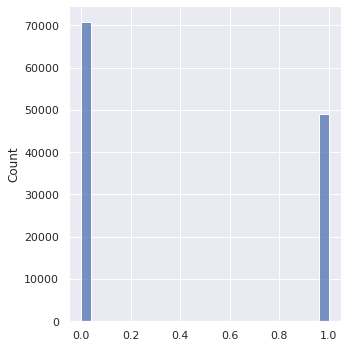

In [47]:
X = data.content.apply(tokenizer).to_list()
y = (data.score >= 4).to_numpy().astype(int)
_ = sns.displot(y)

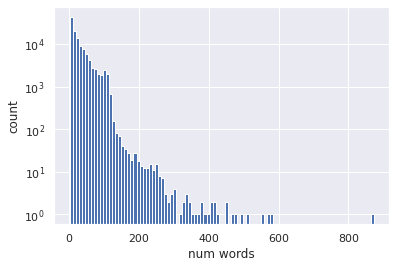

In [48]:
plt.hist([len(sent) for sent in X], bins=100)
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('num words')
plt.show()

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)
len(X_train), len(X_valid)

(89841, 29948)

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [51]:
X_train_sents = [' '.join(sent) for sent in X_train]
X_valid_sents = [' '.join(sent) for sent in X_valid]

In [53]:
tf_idf = TfidfVectorizer(min_df=5).fit(X_train_sents)
tf_idf_train = tf_idf.transform(X_train_sents)
tf_idf_valid = tf_idf.transform(X_valid_sents)

tf_idf_train.shape, tf_idf_valid.shape

((89841, 7595), (29948, 7595))

In [54]:
lr = LogisticRegression(max_iter=1000).fit(tf_idf_train, y_train)

In [55]:
print(f'Tf-idf + LogRegr train acc: {accuracy_score(lr.predict(tf_idf_train), y_train):.4f}')
print(f'Tf-idf + LogRegr valid acc: {accuracy_score(lr.predict(tf_idf_valid), y_valid):.4f}')

Tf-idf + LogRegr train acc: 0.8971
Tf-idf + LogRegr valid acc: 0.8839


In [56]:
def get_sentence_embedding(sent):
    embeds = []
    for word in sent:
        embeds += [ft.get_word_vector(word)]

    return np.stack(embeds, axis=0).mean(0)

In [57]:
train_embeds = np.stack([get_sentence_embedding(sent) for sent in X_train], axis=0)
valid_embeds = np.stack([get_sentence_embedding(sent) for sent in X_valid], axis=0)

In [58]:
lr = LogisticRegression(max_iter=1000).fit(train_embeds, y_train)

In [59]:
print(f'FastText + LogRegr train acc: {accuracy_score(lr.predict(train_embeds), y_train):.4f}')
print(f'FastText + LogRegr valid acc: {accuracy_score(lr.predict(valid_embeds), y_valid):.4f}')

FastText + LogRegr train acc: 0.8564
FastText + LogRegr valid acc: 0.8568


In [60]:
BATCH_SIZE = 128
MAX_SEQUENCE_LENGTH = 256
MODEL_BLOCKS = 2
MODEL_CHANNELS = 300
NUM_EPOCHS = 5

In [61]:
class EmbeddingsDataset(Dataset):
    def __init__(self, sents, targets, max_length):
        super().__init__()

        self.max_length = max_length
        self.sents = sents
        self.targets = targets

    def __len__(self):
        return len(self.sents)

    def __getitem__(self, item):
        sent = self.sents[item]
        length = min(len(sent), self.max_length)

        embeds = []
        for word in sent[:length]:
            embeds += [torch.from_numpy(ft.get_word_vector(word).astype(np.float32))]

        embeds = torch.stack(embeds, dim=1)
        padding = torch.zeros((embeds.shape[0], self.max_length - length))
        embeds = torch.cat([embeds, padding], dim=1)
        target = self.targets[item]
        return embeds, length, target

In [62]:
train_set = EmbeddingsDataset(X_train, y_train, max_length=MAX_SEQUENCE_LENGTH)
valid_set = EmbeddingsDataset(X_valid, y_valid, max_length=MAX_SEQUENCE_LENGTH)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=8,
                          pin_memory=True, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, num_workers=8,
                         pin_memory=True, shuffle=False)

In [63]:
class BasicBlock(nn.Module):
    def __init__(self, num_channels, kernel_size):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv1 = nn.Conv1d(num_channels, num_channels, kernel_size,
                               padding=padding, bias=False)
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.conv2 = nn.Conv1d(num_channels, num_channels, kernel_size,
                               padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(num_channels)
        self.relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out + x)
        return out

class TextCNN(nn.Module):
    def __init__(self, num_blocks, num_channels, num_classes, kernel_size=5):
        super().__init__()

        self.backbone = nn.Sequential(
            *[BasicBlock(num_channels, kernel_size) for _ in range(num_blocks)]
        )

        self.classifier = nn.Linear(num_channels, num_classes)

    @staticmethod
    def get_lengths_mask(embeds, lengths):
        mask = torch.arange(embeds.shape[-1]).unsqueeze(0).to(embeds.device)
        mask = (mask < lengths.unsqueeze(1)).to(torch.float)
        return mask.unsqueeze(1)

    def forward(self, embeds, lengths):
        # embeds: (B, C, T), lengths: (B, )
        features = self.backbone(embeds)
        # features: (B, C, T)
        mask = self.get_lengths_mask(embeds, lengths)
        # mask: (B, 1, T)
        features = (features * mask).sum(-1) / lengths.unsqueeze(1)
        # features: (B, C)
        logits = self.classifier(features)
        # logits: (B, num_classes)
        return logits

In [64]:
def train(model: nn.Module, data_loader: DataLoader, optimizer: Optimizer, loss_fn, device: torch.device):
    model.train()

    total_loss = 0
    total_correct = 0

    for embeds, lengths, labels in tqdm(data_loader):
        embeds, lengths, labels = embeds.to(device), lengths.to(device), labels.to(device)

        embeds = embeds[..., :lengths.max()]

        optimizer.zero_grad()

        output = model(embeds, lengths)

        loss = loss_fn(output, labels)

        loss.backward()

        total_loss += loss.item()
        total_correct += (output.argmax(1) == labels).sum().item()

        optimizer.step()

    return total_loss / len(data_loader), total_correct / len(data_loader.dataset)


In [65]:
@torch.inference_mode()
def evaluate(model: nn.Module, data_loader: DataLoader, loss_fn, device: torch.device):
    model.eval()

    total_loss = 0
    total_correct = 0

    for embeds, lengths, labels in tqdm(data_loader):
        embeds, lengths, labels = embeds.to(device), lengths.to(device), labels.to(device)

        embeds = embeds[..., :lengths.max()]

        output = model(embeds, lengths)

        loss = loss_fn(output, labels)

        total_loss += loss.item()

        total_correct += (output.argmax(dim=1) == labels).sum().item()

    return total_loss / len(data_loader), total_correct / len(data_loader.dataset)


In [66]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()

    plt.show()
    
    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()

    plt.show()

In [67]:
from IPython.display import clear_output


def fit(model, train_loader, valid_loader, optimizer, loss_fn, device, num_epochs, title, scheduler=None):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader, optimizer, loss_fn, device)
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        
        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )
        
        if scheduler is not None:
            scheduler.step()

In [68]:
model = TextCNN(num_blocks=MODEL_BLOCKS, num_channels=MODEL_CHANNELS, num_classes=2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, NUM_EPOCHS)

criterion = nn.CrossEntropyLoss()

In [69]:
fit(model, train_loader, valid_loader, optimizer, loss_fn, device, NUM_EPOCHS, 'TextCNN', scheduler)